# Code Assignment 17 — K-Means Model Comparison with CH & DB + Assumption Testing (Mall Customers)

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:**  Compare **two feature sets** for K-Means at the **same K**:  
- **Model 1:** 2 features → `['Annual Income (k$)', 'Spending Score (1-100)']`  
- **Model 2:** 3 features → `['Age', 'Annual Income (k$)', 'Spending Score (1-100)']`  
Evaluate with **Silhouette (↑), Calinski–Harabasz (↑), Davies–Bouldin (↓)**, **separation ratio** (↑), **cluster sizes**, and **stability (median ARI) (↑)**.



## Instructor Guidance (Pseudocode + Docs)

**Docs**  
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
- `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- `silhouette_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html  
- `calinski_harabasz_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html  
- `davies_bouldin_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html  
- `adjusted_rand_score` (stability): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

### Pseudocode Plan (Model Comparison)
  1) Load CSV → pick clean numeric columns (2D vs 3D).  
  2) **Scale** each feature set **separately** with `StandardScaler`.  
  3) Fix **K** (e.g., K=4).  
  4) Fit KMeans on each set → get labels & centers.  
  5) Compute metrics: `silhouette_score` (↑), `calinski_harabasz_score` (↑), `davies_bouldin_score` (↓).  
  6) Assumption checks: **separation ratio** (min between-centroid distance ÷ max within-cluster spread), **cluster sizes** (%), **stability via ARI** across seeds.  
  7) Compare models in a table → pick one and justify.


## Your Task — Step-by-Step
Work in pairs. Keep it minimal and clear.

### 0) Run Helper Functions and do your Imports

In [1]:
# RUN THIS CELL WITHOUT CHANGES 

def cluster_size_pct(labels):
    """Return % size of each cluster (sorted by cluster index)."""
    s = pd.Series(labels).value_counts(normalize=True).sort_index()
    return (s * 100).round(1)

def within_between_ratio(Z, labels, centers):
    """
    Heuristic separation metric:
    min distance among centroids ÷ max within-cluster spread (avg feature std per cluster).
    Higher is better (more separated vs within spread).
    """
    within = []
    for c in range(centers.shape[0]):
        pts = Z[labels == c]
        if len(pts) == 0:
            within.append(np.nan)
        else:
            within.append(pts.std(axis=0).mean())
    within = np.array(within, dtype=float)
    max_within = np.nanmax(within)

    D = cdist(centers, centers)  # centroid distance matrix
    np.fill_diagonal(D, np.nan)
    min_between = np.nanmin(D)
    return float(min_between / max_within)

def stability_ari(Z, k, seeds=(0, 1, 2, 3, 4)):
    """
    Fit KMeans across multiple seeds and compute median Adjusted Rand Index across pairs.
    Higher median ARI = more stable clustering to initialization.
    """
    label_sets = []
    for s in seeds:
        km = KMeans(n_clusters=k, n_init=10, random_state=s).fit(Z)
        label_sets.append(km.labels_)
    pairs = [(i, j) for i in range(len(label_sets)) for j in range(i+1, len(label_sets))]
    aris = [adjusted_rand_score(label_sets[i], label_sets[j]) for (i, j) in pairs]
    return float(np.median(aris))


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### 1) Load the Mall Customers CSV & Preview
Use the same dataset as last time.

In [7]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/Mall_Customers copy.csv')

### 2) Build 2D and 3D feature sets (numeric only, minimal cleaning)

- 2D set:  Annual Income and Spending Score
- 3D set:  Age, Annual Income, Spending Score 

**Be sure to scale!**


In [8]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [11]:
# X2 for 2d set nad X3 for 3d set
X2 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X3 = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

In [12]:
# Scale both predictors sets
scaler2 = StandardScaler()
scaled2_X2 = scaler2.fit_transform(X2)

scaler3 = StandardScaler()
scaled3_X3 = scaler3.fit_transform(X3)

### 3) Choose a single k for BOTH models (you can try 3, 4, 5, etc.)

In [33]:
K_FIXED = 3
print('Using K =', K_FIXED)

Using K = 3


### 4) Fit Model 1 (2D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!
-  KMeans, silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
- quick note on adjust rand score: it measures stability.
    - It checks: “If I run KMeans again, do I get the same clusters?”
    - compares two sets of labels and sees how similar they are.
    - Score ranges from 0 to 1.
    - 1 = perfect stability (same labels every run).
    - 0 = random / unstable.
    - High score = your clusters are consistent, not changing with different random seeds.

In [28]:
km2 = KMeans(n_clusters=K_FIXED, random_state=0)
labels2 = km2.fit_predict(scaled2_X2)

centers2 = km2.cluster_centers_

sil2 = silhouette_score(scaled2_X2, labels2)
ch2 = calinski_harabasz_score(scaled2_X2, labels2)
db2 = davies_bouldin_score(scaled2_X2, labels2)
ratio2 = within_between_ratio(scaled2_X2, labels2, centers2)
sizes2 = cluster_size_pct(labels2)
stability2 = stability_ari(scaled2_X2, k=K_FIXED)

print("Model 1 (2D):")
print("Silhouette:", sil2)
print("CH:", ch2)
print("DB:", db2)
print("Separation Ratio:", ratio2)
print("Cluster Sizes (%):", sizes2)
print("Stability Adjusted rand score:", stability2)


Model 1 (2D):
Silhouette: 0.5546571631111091
CH: 248.64932001536357
DB: 0.5722356162263351
Separation Ratio: 3.1425974906339635
Cluster Sizes (%): 0   40.5000
1   19.5000
2   17.5000
3   11.5000
4   11.0000
Name: proportion, dtype: float64
Stability Adjusted rand score: 1.0


### 5) Fit Model 2 (3D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!
- Use same k as Model 1

In [29]:
km3 = KMeans(n_clusters=K_FIXED, random_state=0)
labels3 = km3.fit_predict(scaled3_X3)

sil3 = silhouette_score(scaled3_X3, labels3)
ch3  = calinski_harabasz_score(scaled3_X3, labels3)
db3  = davies_bouldin_score(scaled3_X3, labels3)
ratio3 = within_between_ratio(scaled3_X3, labels3, km3.cluster_centers_)
sizes3 = cluster_size_pct(labels3)
stability3 = stability_ari(scaled3_X3, k=K_FIXED)

print("Model 2 (3D):")
print("Silhouette:", sil3)
print("CH:", ch3)
print("DB:", db3)
print("Separation Ratio:", ratio3)
print("Cluster Sizes (%):", sizes3)
print("Stability Adjusted rand score:", stability3)


Model 2 (3D):
Silhouette: 0.41664341513732767
CH: 125.10094020060956
DB: 0.874551051002418
Separation Ratio: 2.794037048691251
Cluster Sizes (%): 0   23.5000
1   19.5000
2   20.0000
3   10.0000
4   27.0000
Name: proportion, dtype: float64
Stability Adjusted rand score: 1.0


### 6) Visualize Model 1 (2D Scatter Plot)


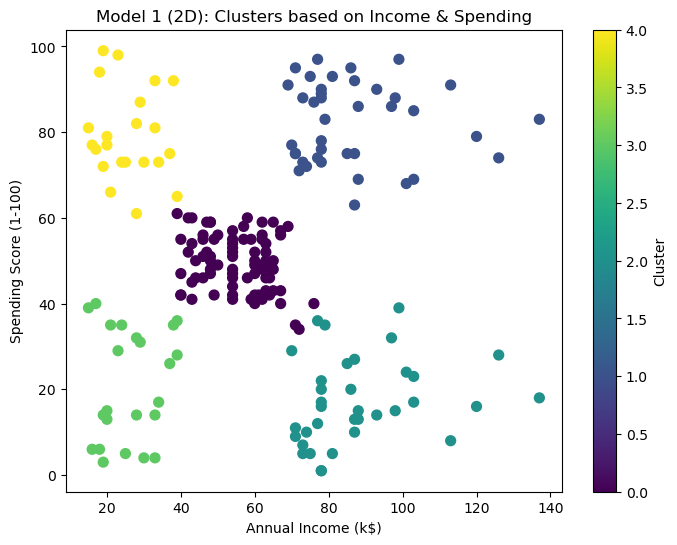

In [32]:
#visualize model 1

x = X2.iloc[:, 0]   # Annual Income
y = X2.iloc[:, 1]   # Spending Score

plt.figure(figsize=(8,6))
plt.scatter(x, y, c=labels2, cmap='viridis', s=50)

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Model 1 (2D): Clusters based on Income & Spending")
plt.colorbar(label="Cluster")
plt.show()


## We Share — Reflection (short, specific)
1) **Which model is better and why?** Reference **Sil (↑), CH (↑), DB (↓)**, **separation ratio (↑)**, **stability ARI (↑)**, and **cluster sizes**. 
    - For my comparison, Model 1 (2D) was the better model. The silhouette score, CH score, and separation ratio were all higher for Model 1, which means the clusters were tighter and more separated. Model 1 also had a lower DB score, showing less overlap between groups. The clusters were more balanced and the stability ARI was perfect. When I added Age in the 3D model, the clusters got weaker and more mixed, so the simpler 2D version actually performed better.

2) **Assumptions & ethics:** Did your chosen model show **non-overlapping, roughly spherical, similarly dense** clusters? If not, what risk could that pose to stakeholders (mis-targeted offers, unfair treatment)? 
    - My chosen model creates clusters that are mostly separated, but I have to remember that this is only based on income and spending score. These clusters assume customers behave in simple patterns, and real people are more complex. If the clusters were wrong or overlapped, it could lead to mistargeted offers or unfair treatment of customers. I would need to make sure the model does not reinforce bias or treat certain groups differently just based on spending.

3) **Next step:** If you had to ship this, what monitoring would you add (e.g., re-check metrics quarterly, watch for tiny cluster drift, re-scale after schema changes)?
     - If I had to ship this, I would keep an eye on the model over time. I would re-check the metrics each quarter, make sure the clusters are still stable, and watch for any tiny clusters forming. If the data changes, I would re-scale and re-fit the model. I would also talk to stakeholders to see if these clusters actually help with marketing decisions or if I need to adjust the features.

> Tip: If metrics conflict (e.g., CH prefers K=6, DB prefers K=4), prefer **parsimonious K** with **clear separation**, **stable labels**, and **business actionability**.
